In [5]:
from mb_sql.conn import get_engine, get_session
from mb_sql.sql import read_sql
from mb_sql.utils import list_schemas,list_tables

In [6]:
engine = get_engine(name='postgresql' , db= 'postgres', user='postgres' , password= 'postgres', host= 'localhost', port= 5432, echo=False)
session = get_session(engine)

In [3]:
print(list_schemas(engine),f'\n\n',list_tables(engine, schema='public'))

    schema_name
0  embeddingsDB
1    pg_catalog
2      pg_toast
3        public
4      ytshorts 

        table_name
0     download_db
1  download_queue
2       merged_db
3    mix_video_db
4   transcript_db


In [4]:
read_sql('''SELECT
    column_name,
    data_type,
    character_maximum_length,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_name = 'download_db'
ORDER BY ordinal_position;''', engine)

,column_name,data_type,character_maximum_length,is_nullable,column_default
0,yt_link,text,None,NO,None
1,local_link,text,None,YES,None
2,download,boolean,None,YES,None
3,date,date,None,YES,None
4,time,time without time zone,None,YES,None


In [5]:
read_sql('SELECT * FROM public.download_db limit 3;', engine)

,yt_link,local_link,download,date,time
0,https://www.youtube.com/watch?v=_nPQk65D3xE,/home/malav/Desktop/ytshorts_files/yt_download...,True,2025-05-23,02:04:29.359650
1,https://www.youtube.com/watch?v=_nPQk65D3xE,/home/malav/Desktop/ytshorts_files/yt_download...,True,2025-05-23,02:13:34.967209
2,https://www.youtube.com/watch?v=_nPQk65D3xE,/home/malav/Desktop/ytshorts_files/yt_download...,True,2025-05-23,02:16:29.363057


In [6]:
data = read_sql('SELECT * FROM public.download_db limit 3;', engine)
print(data.head(2))

                                       yt_link  \
0  https://www.youtube.com/watch?v=_nPQk65D3xE   
1  https://www.youtube.com/watch?v=_nPQk65D3xE   

                                          local_link  download        date  \
0  /home/malav/Desktop/ytshorts_files/yt_download...      True  2025-05-23   
1  /home/malav/Desktop/ytshorts_files/yt_download...      True  2025-05-23   

              time  
0  02:04:29.359650  
1  02:13:34.967209  


In [7]:
from mb_rag.agents.get_langsmith import set_langsmith_parameters

In [7]:
from mb_rag.utils.extra import load_dotenv
load_dotenv()

True

In [9]:
set_langsmith_parameters(langsmith_endpoint="https://api.smith.langchain.com",
                        langsmith_project="SQL-Agent-Project",
                        langsmith_tracing="true")

In [10]:
from mb_rag.agents.sql_agents import runtime_sql_agent,run_sql_agent

In [11]:
## testing engine
testing = runtime_sql_agent(engine)
testing.test_basic_mb()


    schema_name
0  embeddingsDB
1    pg_catalog
2      pg_toast
3        public
4      ytshorts 

        table_name
0     download_db
1  download_queue
2       merged_db
3    mix_video_db
4   transcript_db


In [8]:
from mb_rag.basic import ModelFactory

llm = ModelFactory(model_name="gemini-2.0-flash",model_type='google')
llm.invoke_query('What is the capital of France?')

'The capital of France is **Paris**.'

In [13]:
main_agent = run_sql_agent(llm=llm.model,db_connection=engine)

In [14]:
main_agent.run('List all tables in the database?')

[Agent Error] Expected dict, got List all tables in the database?
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_GRAPH_NODE_RETURN_VALUE


'Expected dict, got List all tables in the database?\nFor troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_GRAPH_NODE_RETURN_VALUE'

In [ ]:
# print(main_agent.agent.invoke({'input': 'List all tables in the database?'}))

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents: contents is not specified


In [9]:
from langchain_community.utilities.sql_database import SQLDatabase

In [10]:
db = SQLDatabase(engine=engine)

In [11]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm.model)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [12]:
system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

In [135]:
from langchain_core.callbacks  import BaseCallbackHandler
import time
from langchain.agents.middleware import wrap_model_call, wrap_tool_call,before_model,after_model

# @wrap_tool_call
# class DebugCallback(BaseCallbackHandler):
#     def __init__(self):
#         self.events = []

# @wrap_tool_call
@before_model
def on_chain_start(reqest, run_id=None, parent_run_id=None, tags=None, metadata=None, **kwargs):
    # print(f"Chain started with run_id: {run_id}")
    print(f'Time start : {time.time()}')
    time_start = time.time()
    print(f"Inputs: {reqest}")
    time_end = time.time()
    print(f"Time taken: {time_end - time_start} seconds")
    # return None
    # print(f"Inputs: {inputs}")
    # events= []
    # events.append({
    #     "event": "start",
    #     "run_id": run_id,
    #     "start_time": time.time(),
    #     "input": inputs,
    #     "metadata": metadata,
    # })

# @after_model(can_jump_to=['end'])
# @after_model(can_jump_to=['end'])
# def on_chain_end(outputs, run_id):
#     # print(f"Chain ended with outputs: ")
#     print(f"Outputs: {outputs}")
#     print(f"Run ID: {run_id}")

# callback = DebugCallback()

In [136]:
from langchain.agents import create_agent

agent = create_agent(
    llm.model,
    tools,
    system_prompt=system_prompt,
    debug=False,
    middleware=[on_chain_start],
)

In [138]:
question = "combine the tables download_db and download_queue and give me 5 results?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

combine the tables download_db and download_queue and give me 5 results?
Time start : 1762824845.3590612
Inputs: {'messages': [HumanMessage(content='combine the tables download_db and download_queue and give me 5 results?', additional_kwargs={}, response_metadata={}, id='84091ebf-01df-4ba9-bbee-34dedc6c817a')]}
Time taken: 7.367134094238281e-05 seconds
================================== Ai Message ==================================

I cannot combine tables without knowing their schemas. First, I need to know the table names in the database.
Tool Calls:
  sql_db_list_tables (cc546ea2-ba1f-4327-87cb-6ead6e8433cc)
 Call ID: cc546ea2-ba1f-4327-87cb-6ead6e8433cc
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

download_db, download_queue, merged_db, mix_video_db, transcript_db
Time start : 1762824846.000235
Inputs: {'messages': [HumanMessage(con

In [23]:
from mb_rag.utils.viewer import display_graph_png

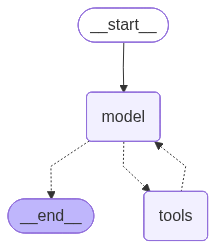

In [65]:
display_graph_png(agent)